In [5]:
%matplotlib inline

In [31]:
from astropy.table import Table 
chain = Table.read('chain.dat', format='ascii')
print(chain.keys())

chain.sort('lnprob')

ilast = -100
print(chain['prob_disrupt'][ilast:].min(), chain['prob_disrupt'][ilast:].max())
print(chain['frac_disrupt'][ilast:].min(), chain['frac_disrupt'][ilast:].max())

['prob_disrupt', 'frac_disrupt', 'lnprob']
(0.1216, 0.22059999999999999)
(0.40999999999999998, 0.65229999999999999)


In [44]:
from empirical_disk_bulge.observations import load_umachine_sdss_complete

sdss = load_umachine_sdss_complete()
mask = sdss['type_mendel13'] != 4
mask *= sdss['deltaBD_mendel13'] <= 1
cut_sdss = sdss[mask]

from empirical_disk_bulge.observations import sfr_sequence_bulge_disk_fractions_vs_sm as bt_measurement
_result = bt_measurement(cut_sdss['bt'], cut_sdss['sm'], cut_sdss['ssfr'])
np.save('frac_bulge_disk_vs_sm_mendel13', np.array(_result))
sm_abscissa_sdss, frac_disk_dom_all_sdss, frac_bulge_dom_all_sdss,\
    frac_disk_dom_sfs_sdss, frac_bulge_dom_sfs_sdss, \
    frac_disk_dom_gv_sdss, frac_bulge_dom_gv_sdss, \
    frac_disk_dom_q_sdss, frac_bulge_dom_q_sdss = _result


In [38]:
from empirical_disk_bulge.models import random_constant_disruption

def model_prediction(x, sm, ssfr, smh, sfrh, tarr):
    prob_disrupt = min(1, max(0, x[0]))
    frac_disrupt = min(1, max(0, x[1]))
    zobs = 0.
    sm_disk, sm_bulge = random_constant_disruption(sfrh, smh, tarr, zobs, 
                                                   prob_disrupt, frac_disrupt)
    bt = sm_bulge/(sm_disk + sm_bulge)
    
    return bt_measurement(bt, sm, ssfr, return_data_vector=False)

from umachine_pyio.load_mock import value_added_mock, load_mock_from_binaries
subvolumes = np.random.choice(np.arange(144), 50, replace=False)
vamock = value_added_mock(load_mock_from_binaries(subvolumes), 250)
sfrh, smh = vamock['sfr_history_main_prog'].data, vamock['sm_history_main_prog'].data
sm = np.log10(vamock['obs_sm'].data)
ssfr = np.log10(vamock['obs_sfr'].data/vamock['obs_sm'].data)

from umachine_pyio.load_mock import get_snapshot_times
cosmic_age_array = get_snapshot_times()

Total runtime = 13.58 seconds


In [42]:
best_fit_prob_disrupt, best_fit_frac_disrupt = chain['prob_disrupt'][-1], chain['frac_disrupt'][-1]
x = best_fit_prob_disrupt, best_fit_frac_disrupt
bt_result_model = model_prediction(x, sm, ssfr, smh, sfrh, cosmic_age_array)

In [43]:
sm_abscissa_model, frac_disk_dom_all_model, frac_bulge_dom_all_model,\
    frac_disk_dom_sfs_model, frac_bulge_dom_sfs_model, \
    frac_disk_dom_gv_model, frac_bulge_dom_gv_model, \
    frac_disk_dom_q_model, frac_bulge_dom_q_model = bt_result_model


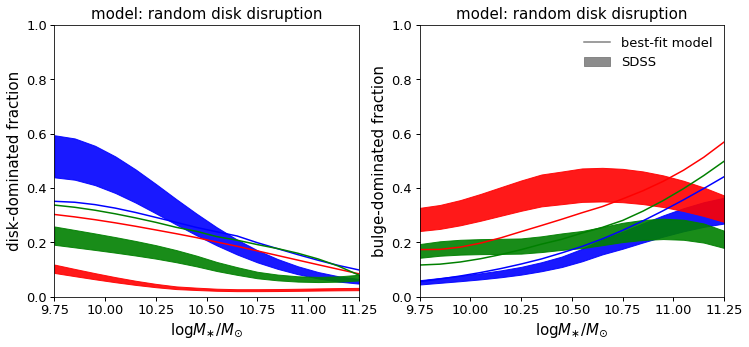

In [58]:

    
from scipy.signal import savgol_filter

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

a, b = 11, 3

fracerr = 0.15
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_disk_dom_sfs_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_disk_dom_sfs_sdss, a, b))
__=ax1.fill_between(sm_abscissa, ylow, yhigh, color='blue', alpha=0.9)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_disk_dom_gv_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_disk_dom_gv_sdss, a, b))
__=ax1.fill_between(sm_abscissa, ylow, yhigh, color='green', alpha=0.9)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_disk_dom_q_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_disk_dom_q_sdss, a, b))
__=ax1.fill_between(sm_abscissa, ylow, yhigh, color='red', alpha=0.9, label='SDSS')

ylow, yhigh = ((1-fracerr)*savgol_filter(frac_bulge_dom_sfs_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_bulge_dom_sfs_sdss, a, b))
__=ax2.fill_between(sm_abscissa, ylow, yhigh, color='blue', alpha=0.9)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_bulge_dom_gv_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_bulge_dom_gv_sdss, a, b))
__=ax2.fill_between(sm_abscissa, ylow, yhigh, color='green', alpha=0.9)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_bulge_dom_q_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_bulge_dom_q_sdss, a, b))
__=ax2.fill_between(sm_abscissa, ylow, yhigh, color='red', alpha=0.9, label='SDSS')

xlabel1 = ax1.set_xlabel(r'$\log M_{\ast}/M_{\odot}$', size=15)
xlabel2 = ax2.set_xlabel(r'$\log M_{\ast}/M_{\odot}$', size=15)
ylabel1 = ax1.set_ylabel(r'disk-dominated fraction', size=15)
ylabel2 = ax2.set_ylabel(r'bulge-dominated fraction', size=15)

xmin, xmax = 9.75, 11.25
xlim1 = ax1.set_xlim(xmin, xmax)
xlim2 = ax2.set_xlim(xmin, xmax)
ymin, ymax = 0, 1
ylim1 = ax1.set_ylim(ymin, ymax)
ylim2 = ax2.set_ylim(ymin, ymax)

__=ax1.plot(sm_abscissa_model, savgol_filter(frac_disk_dom_sfs_model, a, b), 
            color='blue')
__=ax1.plot(sm_abscissa_model, savgol_filter(frac_disk_dom_q_model, a, b), 
            color='red')
__=ax1.plot(sm_abscissa_model, savgol_filter(frac_disk_dom_gv_model, a, b), 
            color='green', label='best-fit model')

__=ax2.plot(sm_abscissa_model, savgol_filter(frac_bulge_dom_sfs_model, a, b), 
            color='blue')
__=ax2.plot(sm_abscissa_model, savgol_filter(frac_bulge_dom_q_model, a, b), 
            color='red')
__=ax2.plot(sm_abscissa_model, savgol_filter(frac_bulge_dom_gv_model, a, b), 
            color='green', label='best-fit model')


legend2 = ax2.legend()
legend2.legendHandles[0].set_color('gray')
legend2.legendHandles[1].set_color('gray')

title1 = ax1.set_title(r'model: random disk disruption')
title2 = ax2.set_title(r'model: random disk disruption')

fig.savefig('best_fit_random_disruption.pdf', 
            bbox_extra_artists=[xlabel1, ylabel1], bbox_inches='tight')
